# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.781891,False,0.387390
1,0.870782,False,-1.129183
2,-0.093696,True,7.159128
3,0.351093,True,5.115276
4,1.265067,False,0.173113
...,...,...,...
995,-0.154945,False,-1.722020
996,1.345329,False,0.914354
997,0.580256,True,4.642386
998,0.952156,False,1.785742


<Axes: xlabel='v0'>

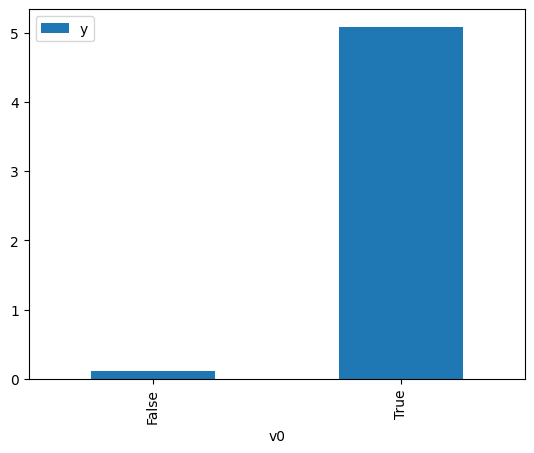

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

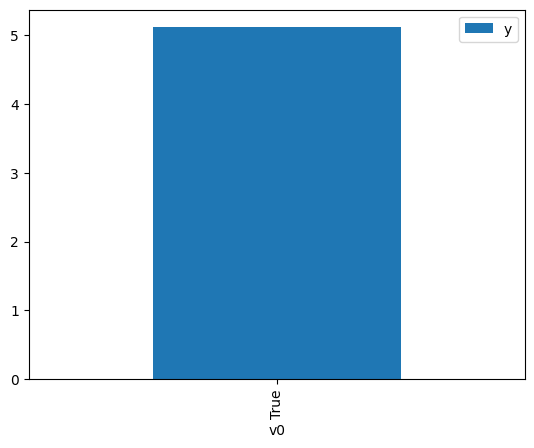

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.188278,False,1.290284,0.483839,2.066804
1,0.028908,False,1.607867,0.472148,2.117982
2,0.556427,False,-0.796434,0.443903,2.252744
3,2.459039,False,0.225063,0.346192,2.888574
4,-0.100968,False,-0.653425,0.479136,2.087090
...,...,...,...,...,...
995,0.910922,False,0.123965,0.425113,2.352315
996,1.041682,False,-0.095624,0.418233,2.391009
997,-0.322524,False,-0.690124,0.491075,2.036349
998,0.303651,False,0.244013,0.457403,2.186254


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.218669,True,4.191087,0.514524,1.943545
1,2.934446,True,6.346822,0.676644,1.477883
2,-0.634608,True,5.340087,0.492094,2.032133
3,0.352200,True,5.885853,0.545195,1.834206
4,-0.523283,True,3.163376,0.498098,2.007638
...,...,...,...,...,...
995,1.667235,True,5.699182,0.614198,1.628140
996,0.581155,True,3.079788,0.557414,1.794000
997,-0.388253,True,4.392206,0.505381,1.978707
998,0.984084,True,6.050734,0.578740,1.727892


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.936
Model:                            OLS   Adj. R-squared (uncentered):              0.936
Method:                 Least Squares   F-statistic:                              7359.
Date:                Tue, 10 Jun 2025   Prob (F-statistic):                        0.00
Time:                        16:55:58   Log-Likelihood:                         -1415.9
No. Observations:                1000   AIC:                                      2836.
Df Residuals:                     998   BIC:                                      2846.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3877      0.031     12.569      0.000       0.327       0.448
x2             5.0039      0.045    111.778      0.000       4.916       5.092
==============================================================================
Omnibus:                        2.260   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.323   Jarque-Bera (JB):                2.211
Skew:                          -0.070   Prob(JB):                        0.331
Kurtosis:                       2.818   Cond. No.                         1.62
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""